<a href="https://colab.research.google.com/github/udsey/SATO_RL/blob/main/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Для графиков в Git

In [ ]:
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
# Для отрисовки статического изображения в git
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 1300
svg_renderer.height = 600
svg_renderer.engine = 'kaleido' #static image generation dependency, install it using pip or conda.

pio.renderers.default = "svg"  # set as default renderer (optional)

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers

# Функции

In [301]:
def limit_plot(df, return_df = False, plot=True):
    import plotly.graph_objects as go
    df_lim = df.copy()
    df_lim['x'] = df_lim.apply(lambda x: np.arange(x[0], x[1], 0.1), axis=1)
    df_lim = df_lim.explode('x')
    df_lim.drop(columns=df_lim.columns[0:2], inplace=True)
    df_lim.rename(columns={df_lim.columns[0]:'y'}, inplace=True)
    df_lim['y'] *= 3600/1000
    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df_lim.x, y=df_lim.y, name='speed limit'))
        fig.show()
    if return_df == True:
        return df_lim
def plot_stat(hist, total_reward_list):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist)
    plt.title('Iteration number') 
    plt.subplot(1, 2, 2)
    plt.plot(total_reward_list)
    plt.title('Total reward')      

def plot_result(df, df_limit_speed):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_limit_speed.x, y=df_limit_speed.y, name='speed limit'))
    fig.add_trace(go.Scatter(x = df['position_m'], y = df['speed_km/h'], name='train movement'))
    #fig.show('svg')
    fig.show()

def min_time(s, v, a=0.5):
    s*=1000
    v = v / 3.6
    t = v/a
    s_0 = a*t**2/2
    s_ost = s-s_0
    t_1 = s_ost/v
    t_min  = t+t_1
    return t_min

def ideal_driving(v_limit, s, t, dt):
    env = Train(t, v_limit, s, dt)
    done = False
    state = env.reset()
    v_limit = v_limit*1000/3600
    v = 0
    sum_reward = 0
    action = 0
    pos_action = env.action_high
    state_list = []
    action_list = []
    state_list.append(state)
    while not done:
        v += action * dt
        next_v = v + env.action_high * dt
        #next_v = v
        if next_v <= v_limit:
            action = env.action_high
        elif v == v_limit:
            action = 0
        else:
            action = (v_limit - next_v)/dt
        state, reward, done = env.step(action)
        state_list.append(state)
        action_list.append(action)
        sum_reward += reward
    df = env.legend()
    df_limit_speed = limit_plot(env.df_limit, return_df=True, plot=False)
    print('Total reward = ', sum_reward)
    plot_result(df, df_limit_speed)
    state_list = state_list[:-1]
    return df, state_list, action_list

# Модель поезда


Состояние - позиция, скорость, скоростной лимит

Действие - ускорение в диапазоне [-0.5, 0.5]

Вознграждения:

* -1000 - движение в обратном направлении
* -500 - превышение скорости
* -100 - превышение лимита времени
* +1 - движение с допустимой скоростью

In [262]:
class Train:


    def __init__(
                 self, 
                 time_limit=2000, # (sec), available time for the route;
                 v_limit=100, # (km/h), speed limit on the route;
                 s_limit=300, # (km), distance;
                 dt=10, # (sec), state-changing frequency;
                 ):

        """

        Init train

        Parameters:
        time_limit - (sec), available time for the route;
        v_limit - (km/h), speed limit on the route;
        s_limit - (km), distance;
        dt - (sec), state-changing frequency;

        """

        self.action_dim = 1
        self.state_dim = 3

        self.action_high = 0.5 # m/s**2
        self.action_low = -0.5 # m/s**2
        self.time_limit = time_limit # s
        self.v_limit = v_limit * 1000/3600 # m/s
        self.s_limit = s_limit * 1000 # m
        self.dt = dt # s

        self.df_limit = pd.DataFrame({'start': [0],
                                      'stop': [self.s_limit],
                                      'limit': self.v_limit})
        self.reset()

    def append_velocity_limit(self, limit, start, stop):
        """

        Adds speed limit

        Parameters:
        limit - (km/h), speed limit on the road section;
        start - (km), start point of the current speed limit;
        stop - (km), end point of the current speed limit;

        Return:

        pd.DataFrame with columns start (m), stop (m), limit (m/s)

        """
        self.df_limit = self.df_limit.append({'start': start * 1000,
                                              'stop': stop * 1000,
                                              'limit': limit * 1000/3600},
                                              ignore_index=True)
        return self.df_limit

    def reset_velocity_limit(self):
        """
        Reset all speed limits 
        """
        self.append_velocity_limit(self, limit=self.v_limit, 
                                   position=range(0, self.s_limit))

    def reset(self):
        """

        Reset environment to initial state

        """
        self.s = 0
        self.v = 0
        self.a = 0
        self.done = False
        self.total_time = 0
        self.reward = 0
        self.v_list = []
        self.s_list = []
        self.t_list = []
        self.a_list = []
        self.reward_list = []
        self.done_list = []

        return self.return_state()
    def return_state(self):
        """

        Return current state, 
        a list with structure:[position(m), velocity(m/s), velocity_limit(m/s)]

        """
        return [self.s, self.v, self.speed_limit()]


    def speed_limit(self):
        """

        Return the speed limit at the current point

        """
        if self.s < 0:
            return self.df_limit.iloc[0, 2]
    
        for i in range(self.df_limit.shape[0]):
            min_p = self.df_limit.iloc[i, 0]
            max_p = self.df_limit.iloc[i, 1]
            if min_p <= self.s <= max_p:
                return self.df_limit.iloc[i, 2]
            else:
                return min_p

    def legend(self):

        """
        Return pd.DataFrame with movement history

        """
        df = pd.DataFrame(columns=['time_s', 'position_m', 'speed_m/s', 'speed_km/h', 'acceleration_m/s^2', 'reward', 'done'])
        df['time_s'] = self.t_list
        df['position_m'] = self.s_list
        df['speed_m/s'] = self.v_list
        df['speed_km/h'] = np.round(np.array(self.v_list) * 3600/1000 , 0)
        df['acceleration_m/s^2'] = self.a_list
        df['reward'] = self.reward_list
        df['done'] = self.done_list

        return df


    def add_to_hist_df(self, velocity, time, position,
                       acceleration, reward, done):

        self.v_list.append(velocity)
        self.t_list.append(time)
        self.s_list.append(position)
        self.a_list.append(acceleration)
        self.reward_list.append(reward)
        self.done_list.append(done)


    def reward_func(self):
        """

        Return reward at the current point and flag if the action is done

        """
        
        if self.s < 0 or self.v < 0: # had driven the other way
            return -1000, True
        if self.s >= self.s_limit: # attained destination
            self.s = self.s_limit
            return 100, True
        if self.total_time > self.time_limit: # exceeded time limit
            return -100, True
        if self.v > self.speed_limit(): # exceeded speed limit
            return -500, True
        if self.v <= self.speed_limit(): # moves at an acceptable speed
            return 1, False
        
       
    def step(self, action):

        """
        Step for the environment

        Parameters:
        action - acceleration (m/s^2)

        Return:
        State[], Reward, Done
        """

        
        self.total_time += self.dt # (s) - total operating time
        self.a = action # (m/s^2) - acceleration
        self.s += self.v * self.dt + (self.a * (self.dt ** 2))/2 # (m) - current position
        self.v += (self.a * self.dt) # (m/s) - current speed
        self.reward, self.done = self.reward_func()

        self.add_to_hist_df(self.v, self.total_time,
                       self.s, self.a, self.reward, self.done)
        
        return  self.return_state(), self.reward, self.done 

# DDPG

In [263]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [264]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity
        
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [265]:
def get_actor():
    #last_init = tf.random_uniform_initializer(minval=1, maxval=2)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh")(out)
    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [266]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [267]:
def test_policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to action
    sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [268]:
def test_ddpg(actor_model, best_weights):
    total_episodes = 1 
    actor_model_test = get_actor()
    actor_model_test.set_weights(best_weights)
    prev_state = env.reset()
    episodic_reward = 0
    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = test_policy(tf_prev_state)[0]
            # Recieve state and reward from environment.
        state, reward, done = env.step(action)
        episodic_reward += reward

            # End this episode when `done` is True
        if done:
            break

        prev_state = state
    return (episodic_reward)

# Предсказание

In [302]:
s = 1 #km
v = 100 #km/h
t = min_time(s, v)*1.1
dt = 1

In [303]:
train = Train(s_limit=s, time_limit=t, v_limit=v, dt = dt)
train.reset()
df_limit_speed = limit_plot(train.df_limit, return_df=True)

# Попытка обучить модель двигаться в соответствии с идеальной траекторией

In [304]:
ideal_driving_df, state_list, action_list = ideal_driving(v_limit=v, s=s, t=t, dt=dt)

Total reward =  163


In [370]:
ideal_model_actor = get_actor()
ideal_model_critic = get_critic()
ideal_model_actor.compile(optimizer='Adam', loss='mean_squared_error')
ideal_model_critic.compile(optimizer='Adam', loss='mean_squared_error')
x = state_list
y = action_list
x = np.asarray(x)
y = np.asarray(y)
reward = np.asarray(ideal_driving_df.reward)
history_actor = ideal_model_actor.fit(x, y, epochs=100, verbose=0)
history_critic = ideal_model_critic.fit([x, y], reward, epochs=1000, verbose=0)
ideal_weights_actor = ideal_model_actor.get_weights()
ideal_weights_critic = ideal_model_actor.get_weights()
print('Actor loss:', history_actor.history['loss'][-1])
print('Critic loss:', history_critic.history['loss'][-1])

Actor loss: 0.03549382835626602
Critic loss: 79.25061798095703


In [346]:
env = train

num_states = 3
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_high
lower_bound = env.action_low

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  0.5
Min Value of Action ->  -0.5


In [354]:
std_dev = 0.002
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Set weights of ideal movement
actor_model.set_weights(ideal_weights)
#critic_model.set_weights(ideal_weights)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 3e-3
actor_lr = 3e-3

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.05
# Used to update target networks
tau = 0.03

buffer = Buffer(batch_size=256, buffer_capacity=int(1e6))

ost = 100
delta = 10

Episode * 0 * Avg Reward is ==> -445.0 Max reward ==> -445
Episode * 99 * Avg Reward is ==> -444.82 Max reward ==> -444


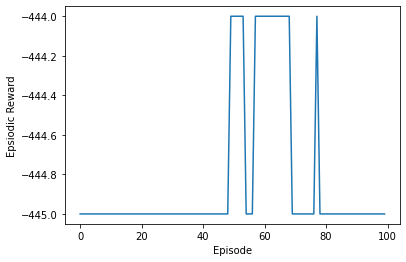

In [172]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    
    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)[0]
        # Recieve state and reward from environment.
        state, reward, done = env.step(action)
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    if ep>2 and episodic_reward > np.max(ep_reward_list):
        best_weights = actor_model.get_weights()


    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-100:])
    if ep % 100 == 0 or ep == total_episodes-1:
        print("Episode * {} * Avg Reward is ==> {} Max reward ==> {}".format(ep, avg_reward, max(ep_reward_list[-100:])))
    avg_reward_list.append(avg_reward)
    if (reward == 100) and (ost - np.mean(ep_reward_list[-10:]) < delta):
        print("Done! Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        avg_reward_list.append(np.mean(ep_reward_list[-10:]))
        break

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()

In [175]:
test_ddpg(actor_model, best_weights)

-445

In [176]:
df = train.legend()
plot_result(df, df_limit_speed)

In [ ]:
s = 1 #km
v = 100 #km/h
t = int(min_time(s, v)*1.1)

In [ ]:
train = Train(s_limit=s, time_limit=t, v_limit=v, dt = 1)
train.reset()
df_limit_speed = limit_plot(train.df_limit, return_df=True)

In [ ]:
v_x = 0
done = False
train.reset()
while not done:
    if v_x < v/1.02:
        a_x = 0.5
    else:
        a_x = 0
    state, reward, done = train.step(a_x)
    v_x = state[1]

In [ ]:
df = train.speed_legend()
df.acceleration /= (3600**2 / 1000)
plot_result(df)

In [ ]:
s = 3 #km
a = 0.5 #m/s**2
v = 10 #km/h
t = int(min_time(s, a, v)*10000)
train = Train(s_limit=s, time_limit=t, v_limit=v, dt = 0.1, v_delta=2)

# задаем ограничения скорости
train.append_velocity_limit(40, 0, 0.5)
train.append_velocity_limit(50, 0.5, 2.5)
train.append_velocity_limit(30, 2.5, 3)
train.df_limit.drop(index = [0], inplace=True)
train.df_limit
df_limit_speed = limit_plot(train.df_limit, return_df=True)

In [ ]:
env = train

num_states = 3
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space_high
lower_bound = env.action_space_low

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  0.5
Min Value of Action ->  -0.5


In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(batch_size=1000, buffer_capacity=int(1e6))

ost = 100
delta = 10

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)[0]
        # Recieve state and reward from environment.
        state, reward, done = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-100:])
    if ep % 100 == 0:
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    if (reward == 100) and (ost - np.mean(ep_reward_list[-10:]) < delta):
        print("Done! Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        avg_reward_list.append(np.mean(ep_reward_list[-10:]))
        break

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

Episode * 0 * Avg Reward is ==> -1000.0
Episode * 100 * Avg Reward is ==> -840.84
Episode * 200 * Avg Reward is ==> -1000.0
Episode * 300 * Avg Reward is ==> -885.59


In [ ]:
df = train.speed_legend()
plot_result(df)